In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_cos_glm import Sub_Cos_GLM
#from models.sub_tcn import Sub_TCN
#from models.gru import GRU
#from models.tcn_multilayer import TCN_Multilayer
#from models.lstm import LSTM
#from models.tcn import TCN
#from models.sub_cos_tcn import Sub_Cos_TCN
#from models.cos_tcn import Cos_TCN
#from models.gru_exp import GRU
#from models.gru_stacked import GRU_Stacked

In [2]:
base_dir = "/scratch/yjk27/"
experiment = "NA_NMDA"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file  = "vdata_T10_Ne2000_gA0.6_tauA1_gN1.2_Ni200_gG0.1_gB0.23_NA0.75_NMDA1.5_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"
V_file = "V_diff_NA0.75_NMDA1.5_stimseed1.npy"

#E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
#I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
E_neural = scipy.sparse.load_npz(base_dir+"CA1_clust4-60/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+"CA1_clust4-60/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)

"""
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)
"""

#####
#V_test_raw = np.load("/media/hdd01/sklee/"+experiment+"/data/V_diff_stimseed1.npy")
#V_test_raw = torch.from_numpy(V_test_raw)
#V_test_raw -= torch.mean(V_test_raw)

#test_E_neural_raw = scipy.sparse.load_npz("/media/hdd01/sklee/"+experiment+"/data/Espikes_neural.npz")
#test_I_neural_raw = scipy.sparse.load_npz("/media/hdd01/sklee/"+experiment+"/data/Ispikes_neural.npz")
#####

C_syn_e = np.load(base_dir+"CA1_clust4-60"+"/data/handsub1_C_syn_e.npy")
C_syn_i = np.load(base_dir+"CA1_clust4-60"+"/data/handsub1_C_syn_i.npy")
C_syn_e = torch.from_numpy(C_syn_e).float()
C_syn_i = torch.from_numpy(C_syn_i).float()

#C_syn_e = C_syn_e[:,e_idx]
#C_syn_i = C_syn_i[:,i_idx]

In [3]:
T_train = 980 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 1
sub_no = 1
E_no = 2000
I_no = 200
#E_no = e_idx.shape[0]
#I_no = i_idx.shape[0]
T_no = 500
#T_no = 350
device = torch.device("cuda:1")

#layer_no = 3

increment = 50
batch_length = 50000
batch_size = 5
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train

In [4]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

#V_test = V_test_raw[50000*993:50000*994].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
#test_E_neural = E_neural[50000*993:50000*994].toarray()
#test_I_neural = I_neural[50000*993:50000*994].toarray()
#test_E_neural = test_E_neural_raw[50000*993:50000*994].toarray()
#test_I_neural = test_I_neural_raw[50000*993:50000*994].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = Sub_Cos_GLM(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
#model = GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = GRU_Stacked(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = Sub_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
#model = LSTM(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, layer_no, device)
#model = Sub_Cos_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, layer_no, device)
#model = Cos_TCN(E_no, I_no, T_no, H_no, layer_no, device)
#model = TCN_Multilayer(T_no-1, 2200, layer_no, H_no, device)

# GLM (1.025 for V_diff, 1 for noNA)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1.035**100))
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.035)

# GRU (1 for V_diff, 1 for noNA)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1**100))
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)

#TCN multilayer
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025,
                             #weight_decay=0.0000001) # for TCNMUlti
                             #weight_decay=0)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2263


In [6]:
score_list = np.empty((iter_no))

for i in tnrange(iter_no):
#for i in tnrange(12000):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _, _ = model(batch_E_neural, batch_I_neural)
    #V_pred, _ = model(batch_E_neural[:,5000:35000,e_idx], batch_I_neural[:,5000:35000,i_idx])
    #V_pred = model(batch_E_neural, batch_I_neural)
    
    train_score = explained_variance_score(batch_V[:,:].flatten().cpu().detach().numpy(),
                                           V_pred.flatten().cpu().detach().numpy())
    
    loss = torch.mean((V_pred- batch_V[:,:] )**2)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out, _ = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        #test_V_pred, test_sub_out = model(test_E_neural.unsqueeze(0)[:,5000:35000,e_idx], test_I_neural.unsqueeze(0)[:,5000:35000,i_idx])
        #test_V_pred = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy()[:], test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[:]-test_V_pred)**2).item()
        score_list[i//50] = test_score
                
        print(i, np.round(test_score,6),
              np.round(train_score,6))


<ipython-input-6-a1715703122f>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 -0.987193 -1.173609
49 -0.156363 -0.173649
99 -0.059359 -0.057053
149 -0.024973 -0.023739
199 -0.008285 -0.009416
249 0.000664 0.000774
299 0.004272 0.008158
349 0.006383 0.011677
399 0.007928 0.013803
449 0.009555 0.0185
499 0.014419 0.028317
549 0.019366 0.035296
599 0.025673 0.0462
649 0.034365 0.054536
699 0.04512 0.04793
749 0.057359 0.065081
799 0.06802 0.088557
849 0.080879 0.079084
899 0.093462 0.113823
949 0.104914 0.118708
999 0.114972 0.102377
1049 0.126158 0.141165
1099 0.135989 0.13752
1149 0.144884 0.134646
1199 0.153799 0.135128
1249 0.160873 0.14476
1299 0.169674 0.1563
1349 0.177112 0.171927
1399 0.18259 0.165979
1449 0.188309 0.163613
1499 0.196064 0.177167
1549 0.200771 0.202589
1599 0.205986 0.184225
1649 0.210916 0.198094
1699 0.2149 0.168144
1749 0.219842 0.181754
1799 0.223673 0.223711
1849 0.227286 0.179288
1899 0.231602 0.204561
1949 0.234549 0.197071
1999 0.238284 0.207972
2049 0.242609 0.22848
2099 0.246172 0.220084
2149 0.248055 0.223899
2199 0.249743 0.21

17699 0.355151 0.302201
17749 0.353114 0.318611
17799 0.355689 0.294644
17849 0.346208 0.322996
17899 0.351938 0.322731
17949 0.358078 0.34467
17999 0.351165 0.309763
18049 0.355794 0.332734
18099 0.353188 0.313398
18149 0.349125 0.32909
18199 0.351286 0.335905
18249 0.356099 0.32381
18299 0.358944 0.297301
18349 0.356142 0.317012
18399 0.35387 0.301606
18449 0.355188 0.30191
18499 0.356646 0.327681
18549 0.35348 0.311806
18599 0.3468 0.307658
18649 0.351912 0.29016
18699 0.359318 0.312023
18749 0.355101 0.33114
18799 0.351027 0.29584
18849 0.357989 0.287611
18899 0.354392 0.329218
18949 0.353682 0.35422
18999 0.357331 0.310863
19049 0.356847 0.347081
19099 0.348278 0.284039
19149 0.356754 0.324329
19199 0.354132 0.322446
19249 0.350668 0.298591
19299 0.356472 0.324238
19349 0.358693 0.355884
19399 0.350435 0.313699
19449 0.357639 0.334223
19499 0.353193 0.309286
19549 0.35521 0.324998
19599 0.360314 0.311594


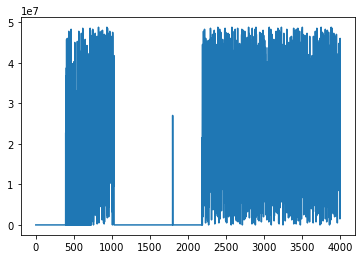

In [7]:
plt.plot(score_list[:4000])
#plt.ylim(0,1)

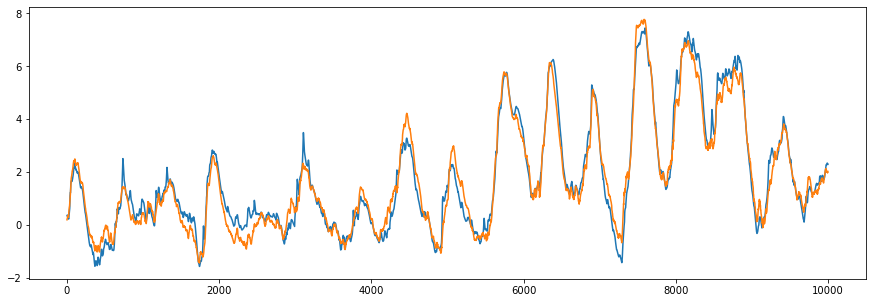

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[17000:27000])
plt.plot(test_V_pred.cpu().detach().numpy()[17000:27000])

In [7]:
#torch.save(model.state_dict(), "/scratch/yjk27/CA1_NA_NMDA/NA0.75_NMDA1.5/na_glm_s1_h1.pt")